# Master DSLS / Programming 3 / Assignment 6
# Final Assignment

## Introduction
https://bioinf.nl/~martijn/master/programming3/assignment6.html

This is the final for programming 3. In this assignment, I will develop scikit-learn machine learning models to predict the function of the proteins in the specific dataset. This model will use small InterPro_annotations_accession to predict large InterPro_annotations_accession.
The definition of small InterPro_annotations_accession and large InterPro_annotations_accession is defined as below:

If InterPro_annotations_accession's feature length(Stop_location-Start_location) / Sequence_length > 0.9, it is large InterPro_annotations_accession.

Otherwise, it is a small InterPro_annotations_accession.

We can briefly rewrite as:

            |(Stop - Start)|/Sequence >  0.9 --> Large

            |(Stop - Start)|/Sequence <= 0.9 --> small

I will also check the "bias" and "noise" that does not make sense from the dataset.

ie. lines(-) from the TSV file which don't contain InterPRO numbers

ie. proteins which don't have a large feature (according to the criteria above)

## 1. Goal

The goal of this assignment is to predict large InterPro_annotations_accession by small InterPro_annotations_accession.

I will use the dataset from /data/dataprocessing/interproscan/all_bacilli.tsv file on assemblix2012 and assemblix2019. However, this file contains ~4,200,000 protein annotations, so I will put a subset of all_bacilli.tsv on GitHub and on local for code testing.

In [1]:
# Spark web UI:http://localhost:4040/jobs/
# Output format : https://interproscan-docs.readthedocs.io/en/latest/OutputFormats.html

# pyspark
import pyspark
import logging
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark_dist_explore import hist

# pyspark ML
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

# ETL & visualization
import numpy as np
import warnings
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create dataframe

def create_dataframe(path, num_rows=None):
    """
    Create a Spark DataFrame from a file with the specified schema.

    Args:
        path (str): The file path.
        num_rows (int): The number of rows to select from the DataFrame (default is None, which processes the entire file).

    Returns:
        pyspark.sql.DataFrame: The Spark DataFrame.
    """
    schema = StructType([
        StructField("Protein_accession", StringType(), True),
        StructField("Sequence_MD5_digest", StringType(), True),
        StructField("Sequence_length", IntegerType(), True),
        StructField("Analysis", StringType(), True),
        StructField("Signature_accession", StringType(), True),
        StructField("Signature_description", StringType(), True),
        StructField("Start_location", IntegerType(), True),
        StructField("Stop_location", IntegerType(), True),
        StructField("Score", FloatType(), True),
        StructField("Status", StringType(), True),
        StructField("Date", StringType(), True),
        StructField("InterPro_annotations_accession", StringType(), True),
        StructField("InterPro_annotations_description", StringType(), True),
        StructField("GO_annotations", StringType(), True),
        StructField("Pathways_annotations", StringType(), True)
    ])
    
    
    # Configure logging to store logs in a file
    logging.basicConfig(filename='/students/2021-2022/master/DaanSteur_DSLS/spark_logs.txt', level=logging.INFO)

    spark = SparkSession.builder.master("local[16]") \
        .config('spark.driver.memory', '128g') \
        .config('spark.executor.memory', '128g') \
        .config("spark.sql.debug.maxToStringFields", "100") \
        .appName("InterPro").getOrCreate()

    # # Set the Spark log level
    # spark.sparkContext.setLogLevel("WARN")

    df = spark.read.option("sep", "\t").option("header", "False").csv(path, schema=schema)

    # If num_rows is None, process the entire file
    if num_rows is not None:
        df = df.limit(num_rows)

    return df


# path = "/data/dataprocessing/interproscan/all_bacilli.tsv"
# data = create_dataframe(path, num_rows=None)
# # get the number of rows
# print("Number of rows: ", data.count())
# data.show(5)

In [3]:
# preprocess data
from pyspark.sql.functions import col, abs, when, max


def data_preprocessing(df):
    """
    It will help you to finish preprocessing data.
    df: spark df
    return small_df,large_df
    """
    # remove InterPro_annotations_accession == "-"
    # get the length of protein
    # get the ratio to distinguish them to large and small InterPro_annotations_accession
    # 1 for large, 0 for small InterPro_annotations_accession
    df = df.filter(df.InterPro_annotations_accession != "-")\
        .withColumn("Ratio", (abs(df["Stop_location"] - df["Start_location"])/df["Sequence_length"]))\
        .withColumn("Size", when((abs(df["Stop_location"] - df["Start_location"])/df["Sequence_length"])>0.9,1).otherwise(0))

    # get the intersection to make sure there is a match of large and small InterPro_annotations_accession(at least one large and one small InterPro_annotations_accession)
    intersection = df.filter(df.Size == 0).select("Protein_accession").intersect(df.filter(df.Size == 1).select("Protein_accession"))
    intersection_df = intersection.join(df,["Protein_accession"])

    # get the number of small InterPro_annotations_accession in each Protein_accession
    small_df = intersection_df.filter(df.Size == 0).groupBy(["Protein_accession"]).pivot("InterPro_annotations_accession").count()

    # There are several InterPro_annotations_accession with the same Protein_accession. I only choose the largest one.
    large_df = intersection_df.filter(df.Size == 1).groupby(["Protein_accession"]).agg(max("Ratio").alias("Ratio"))
    large_df = large_df.join(intersection_df,["Protein_accession","Ratio"],"inner").dropDuplicates(["Protein_accession"])

    # Drop the useless columns
    columns = ("Sequence_MD5_digest","Analysis","Signature_accession","Signature_description",
        "Score","Status","Date","InterPro_annotations_description","GO_annotations",
        "Pathways_annotations","Ratio","Size","Stop_location","Start_location","Sequence_length")
    large_df = large_df.drop(*columns)
    
    print("data preprocessing finished")
    return small_df, large_df

# Example usage:
# small_df, large_df = data_preprocessing(data)

# # Show the first few rows of small_df and large_df
# print("Number of rows in small_df: ", small_df.count())
# small_df.show(5)
# print("Number of rows in small_df: ", large_df.count())
# large_df.show(5)



In [4]:
# ml df created
def ML_df_create(small_df,large_df):
    """
    It will help you to create a correct ML dataframe.
    small_df: spark df, preprocessing to fit the criteria ratio<=0.9
    large_df: spark df, preprocessing to fit the criteria ratio>0.9
    return ML_df
    """
    # Create the df for ML, we do not need Protein_accession anymore.
    ML_df = large_df.join(small_df,["Protein_accession"],"outer").fillna(0).drop("Protein_accession")

    # catalogize y variable
    Label = StringIndexer(inputCol="InterPro_annotations_accession", outputCol="InterPro_index")

    # catalogize X variable
    input_columns = ML_df.columns[1:]
    assembler = VectorAssembler(inputCols=input_columns,outputCol="InterPro_features")

    pipeline = Pipeline(stages=[Label,assembler])
    ML_final = pipeline.fit(ML_df).transform(ML_df)
    
    print("ML dataframe created")
    return ML_final

# ml_final = ML_df_create(small_df, large_df)
# print("Number of rows in ml_final: ", ml_final.count())
# ml_final.show(5)

## Machine learning
Testing machine learning models to predict large InterPro_annotations_accession by small InterPro_annotations_accession.
From earlier papers and communication was found that naivebayes was a strong contenteder for this problem. and therefore i will continue using this model with further testing.


In [5]:
# splitting machine learningdata into training and test sets
def split_data(ML_final, percentage=0.7, seed=42):
    """
    Split the data into training and test sets.

    Args:
        ML_final (DataFrame): The DataFrame to be split.
        percentage (float): The percentage of data to be allocated for training (default is 0.7).
        seed (int): The random seed for reproducibility (default is 42).

    Returns:
        DataFrame, DataFrame: The training and test DataFrames.
    """
    trainData, testData = ML_final.randomSplit([percentage, 1 - percentage], seed=seed)
    
    print(f"Number of rows in trainData: {trainData.count()}, Number of rows in testData: {testData.count()}")
    
    print("Data split into training and test sets")
    return trainData, testData


# train_data, test_data = split_data(ml_final,percentage=0.7)
# train_data.show(5)

Naive bayes 

In [6]:
# import time
# from pyspark.ml.classification import NaiveBayes
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

def train_and_evaluate_naive_bayes_with_cv(model_type, train_data, test_data, output_file):
    # Create the NaiveBayes model with the specified model type
    nb_model = NaiveBayes(modelType=model_type, labelCol="InterPro_index",
                          featuresCol="InterPro_features", predictionCol="prediction")

    # Define hyperparameter grid for smoothing
    param_grid = (ParamGridBuilder()
                  .addGrid(nb_model.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0])
                  .build())

    # Create a MulticlassClassificationEvaluator
    nb_evaluator = MulticlassClassificationEvaluator(labelCol='InterPro_index',
                                                    predictionCol='prediction',
                                                    metricName='accuracy')

    # Create a CrossValidator
    cv = CrossValidator(estimator=nb_model,
                        evaluator=nb_evaluator,
                        estimatorParamMaps=param_grid,
                        numFolds=5,
                        parallelism=10,
                        seed=42)

    # Train the model and measure the time taken
    start_time = time.time()
    cv_model = cv.fit(train_data)
    end_time = time.time()
    training_time_hours = (end_time - start_time) / 3600

    # Make predictions on the test data using the best model from cross-validation
    nb_cv_predictions = cv_model.transform(test_data)

    # Evaluate the model's accuracy
    nb_cv_accuracy = nb_evaluator.evaluate(nb_cv_predictions)

    # Train a separate model on the training data (without cross-validation) to get the initial accuracy
    nb_initial_model = nb_model.fit(train_data)
    nb_initial_predictions = nb_initial_model.transform(test_data)
    nb_initial_accuracy = nb_evaluator.evaluate(nb_initial_predictions)

    # Write accuracies and time taken to a text file
    with open(output_file, 'w') as f:
        f.write(f"Model Type: {model_type}\n")
        f.write(f"Initial Accuracy: {nb_initial_accuracy}\n")
        f.write(f"Cross-Validated Accuracy: {nb_cv_accuracy}\n")
        f.write(f"Time Taken (hours): {training_time_hours}\n")

    print("Model Type:", model_type)
    print("Initial Accuracy:", nb_initial_accuracy)
    print("Cross-Validated Accuracy:", nb_cv_accuracy)
    print("Time Taken (hours):", training_time_hours)
    
    return cv_model, nb_model

# # Example usage:
# cv_model, nb_model = train_and_evaluate_naive_bayes_with_cv("multinomial", train_data, test_data, "nb_multinomial_cv_results.txt")


In [7]:
from pyspark.ml import PipelineModel

def save_spark_model(model, file_path):
    """
    Save a Spark MLlib model to a file.
    
    Args:
        model: Trained Spark MLlib model.
        file_path (str): File path where the model will be saved.
    
    Returns:
        None
    """
    model.save(file_path)
    print(f"Model saved to {file_path}")
        
# save_spark_model(cv_model, "cv_multinomial_model.pkl")

In [8]:
import pandas as pd

def save_dataframe_as_csv(dataframe, file_path):
    """
    Save a Spark DataFrame as a CSV file.
    
    Args:
        dataframe: Spark DataFrame to be saved.
        file_path (str): File path where the CSV file will be saved.
    
    Returns:
        None
    """
    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = dataframe.toPandas()
    
    # Save Pandas DataFrame as CSV
    pandas_df.to_csv(file_path, index=False)
    print(f"DataFrame saved to {file_path}")

# Example usage:
# Assuming you have a Spark DataFrame 'train_data' and want to save it as 'train_data.csv'
# Replace 'train_data' and 'train_data.csv' with your DataFrame and desired file path.
# save_dataframe_as_csv(train_data, 'train_data.csv')


In [10]:
def main():
    path = "/data/dataprocessing/interproscan/all_bacilli.tsv"
    data = create_dataframe(path, num_rows=5000)
    small_df, large_df = data_preprocessing(data)
    ml_final = ML_df_create(small_df, large_df)
    train_data, test_data = split_data(ml_final,percentage=0.7)
    save_dataframe_as_csv(train_data, '/students/2021-2022/master/DaanSteur_DSLS/train_data.csv')
    save_dataframe_as_csv(test_data, '/students/2021-2022/master/DaanSteur_DSLS/test_data.csv')
    
    cv_model, nb_model = train_and_evaluate_naive_bayes_with_cv("multinomial", train_data, test_data, "/students/2021-2022/master/DaanSteur_DSLS/nb_multinomial_cv_results.txt")
    save_spark_model(nb_model, '/students/2021-2022/master/DaanSteur_DSLS/nb_model_multinomial.pkl')
    save_spark_model(cv_model, '/students/2021-2022/master/DaanSteur_DSLS/cv_model_multinomial.pkl')
    
    cv_model, nb_model = train_and_evaluate_naive_bayes_with_cv("gaussian", train_data, test_data, "/students/2021-2022/master/DaanSteur_DSLS/nb_gaussian_cv_results.txt")
    save_spark_model(nb_model, '/students/2021-2022/master/DaanSteur_DSLS/nb_model_gaussian.pkl')
    save_spark_model(cv_model, '/students/2021-2022/master/DaanSteur_DSLS/cv_model_gaussian.pkl')

main()

data preprocessing finished


ML dataframe created


23/09/17 13:27:35 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
23/09/17 13:30:21 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


Number of rows in trainData: 121064, Number of rows in testData: 51524
Data split into training and test sets


23/09/17 13:31:28 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


KeyboardInterrupt: 

data analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Assuming you have a PySpark DataFrame named large_proteins and small_proteins
# Select the feature_Length column and convert it to a NumPy array
large_feature_lengths = large_proteins.select('feature_Length').rdd.flatMap(lambda x: x).collect()
small_feature_lengths = small_proteins.select('feature_Length').rdd.flatMap(lambda x: x).collect()

# Create subplots with a shared y-axis in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey='row')

# Customize the style of the histograms
color_large = 'lightgreen'
color_small = 'orange'
bins = 20

# Plot for small_proteins
axs[0, 0].set_title('Histogram showing the feature length of small Interpro accession')
axs[0, 0].set_xlabel('Feature length (Start-Stop)')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].hist(small_feature_lengths, bins=bins, color=color_small, edgecolor='black', alpha=0.7)

# Plot for large_proteins
axs[0, 1].set_title('Histogram showing the feature length of large Interpro accession')
axs[0, 1].set_xlabel('Feature length (Start-Stop)')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].hist(large_feature_lengths, bins=bins, color=color_large, edgecolor='black', alpha=0.7)



# Add gridlines
for ax in axs[:, 0]:
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Convert PySpark DataFrames to Pandas DataFrames
large_df = large_proteins.toPandas()
small_df = small_proteins.toPandas()

# Set Seaborn theme and style
sns.set_theme(style="whitegrid")

# Plot for small_proteins with light green color
sns.boxplot(x=small_df["feature_Length"], ax=axs[1, 1], color='lightgreen')
axs[1, 0].set_title('Boxplot of small Interpro accessions')
axs[1, 0].set_ylabel('Feature Length')

# Plot for large_proteins with orange color
sns.boxplot(x=large_df["feature_Length"], ax=axs[1, 0], color='orange')
axs[1, 1].set_title('Boxplot of large Interpro accessions')
axs[1, 1].set_ylabel('Feature Length')

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('protein_analys_plots.png')

# Show the combined plot
plt.show()


23/09/17 13:38:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
/tmp/ipykernel_1443121/3328921537.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  MLdf["protein_sum"] = MLdf.iloc[:,17:].sum(axis=1)


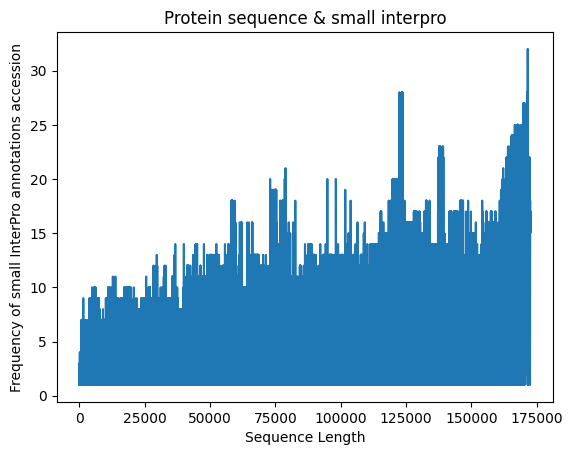

In [11]:
path = "/data/dataprocessing/interproscan/all_bacilli.tsv"
ana_data = create_dataframe(path=path, num_rows=None)

# remove InterPro_annotations_accession == "-"
# get the length of protein
# get the ratio to distinguish them to large and small InterPro_annotations_accession
# 1 for large, 0 for small InterPro_annotations_accession
ana_data = ana_data.filter(ana_data.InterPro_annotations_accession != "-")\
        .withColumn("Ratio", (abs(ana_data["Stop_location"] - ana_data["Start_location"])/ana_data["Sequence_length"]))\
        .withColumn("Size", when((abs(ana_data["Stop_location"] - ana_data["Start_location"])/ana_data["Sequence_length"])>0.9,1).otherwise(0))
        
# get the intersection to make sure there is a match of large and small InterPro_annotations_accession(at least one large and one small InterPro_annotations_accession)
intersection = ana_data.filter(ana_data.Size == 0).select("Protein_accession").intersect(ana_data.filter(ana_data.Size == 1).select("Protein_accession"))
intersection_df = intersection.join(ana_data,["Protein_accession"])

# get the number of small InterPro_annotations_accession in each Protein_accession
small_df = intersection_df.filter(ana_data.Size == 0).groupBy(["Protein_accession"]).pivot("InterPro_annotations_accession").count()

# There are several InterPro_annotations_accession with the same Protein_accession. I only choose the largest one.
large_df = intersection_df.filter(ana_data.Size == 1).groupby(["Protein_accession"]).agg(max("Ratio").alias("Ratio"))
large_df = large_df.join(intersection_df,["Protein_accession","Ratio"],"inner").dropDuplicates(["Protein_accession"])
        
# Create the df for ML, we do not need Protein_accession anymore.
ML_df = large_df.join(small_df,["Protein_accession"],"outer").fillna(0)

# Check the data
# plot the small InterPro_annotations_accession in each Protein_accession
MLdf = ML_df.toPandas()
MLdf["protein_sum"] = MLdf.iloc[:,17:].sum(axis=1)
MLdf = MLdf.sort_values("Sequence_length")

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(np.arange(len(MLdf)),MLdf.protein_sum, color="lightblue",linewidth=1.5)
plt.title("Frequency of Small InterPro Annotations Accession by Sequence Length")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.savefig("Protein_Sequence_Small_InterPro.png")
plt.show()